Получение исходных данных

In [340]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon
place = GoalPolygon('Жилой комплекс "Жулебино Парк" стройка')
v = place.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

In [341]:
def get_xy(s):

    x, y = s.centroid.coords.xy
    return x[0], y[0]

Здесь полигон в нуле не от центра

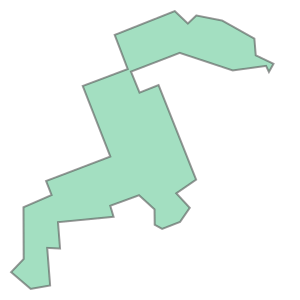

In [342]:
from shapely.affinity import translate

s = v.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)

st

In [343]:
# убрать бы эту ебань
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))
print (coor_list)

[(0.0, 42.42240105941892), (49.646892975317314, 0.0), (98.84738645789912, 8.644872757606208), (91.4870680613094, 103.90478569734842), (123.99432792240987, 102.31525947432965), (118.84098943317076, 169.09848177898675), (259.5926219234825, 182.74853624869138), (251.26317001710413, 210.77966740820557), (324.2408816458192, 237.37195728812367), (363.47268786811037, 201.54586718510836), (363.9113453243044, 162.49007819592953), (382.8016503081308, 152.13047074340284), (428.13861587963765, 169.7247769329697), (452.75512537162285, 205.44482689723372), (418.62160929798847, 242.2890095654875), (468.869841001404, 276.86797133646905), (373.6430417126394, 516.6187753705308), (325.4972854232765, 497.4457708345726), (303.76772698637797, 550.6964679146186), (427.32105774397496, 598.1822010865435), (561.7782090922119, 553.6829920513555), (646.1450598833035, 565.1904505407438), (653.429957066779, 549.7999624321237), (664.9604775389307, 570.4281977945939), (620.0133774741553, 591.985123119317), (616.57404

Декомпозиция периметра

In [344]:
import numpy as np
from math import pi, cos, sin

target = pi/2
basis = np.array([[1, 0, 0],[0, 1, 0]])
tolerance=0.75

In [345]:
transform = np.array(
    [
        [cos(target), -sin(target), 0],
        [sin(target), cos(target), 0],
        [0, 0, 1]
    ]
)

In [346]:
metric = np.complex(np.cross(basis[0], basis[1])[-1],
                             np.cross(basis[1], basis[0])[-1])


/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_9566/2402548898.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metric = np.complex(np.cross(basis[0], basis[1])[-1],


разбиение точек на группы по сегментам

In [347]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) *2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    cross = [*cr, cr[0] + cr[-1] + 1]
    double_points = [*range(len(point_list)), *range(len(point_list))]
    segments = [double_points[cross[c]:cross[c + 1]+1] for c in range(len(cross) - 1)]
    return segments

In [348]:
bb = vec_search(coor_list, 0.5)
print(bb)

[[3, 4, 5], [5, 6, 7], [7, 8], [8, 9], [9, 10, 11, 12, 13, 14], [14, 15, 16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22, 23, 24], [24, 25, 26], [26, 27, 28], [28, 29, 30, 31], [31, 32, 33], [33, 34, 35], [35, 36, 37], [37, 0, 1, 2, 3]]


вектора разбитые по группам от исходных точек

In [349]:
def chains (point_list):
    key_val = vec_search(point_list, 0.5)
    vectors =[]
    for i in key_val:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors


In [350]:
res_vec = chains(coor_list)
print(res_vec)

[[[-32.507259861100465, 1.5895262230187654], [5.153338489239104, -66.7832223046571]], [[-140.75163249031175, -13.650054469704628], [8.329451906378381, -28.03113115951419]], [[-72.97771162871504, -26.5922898799181]], [[-39.2318062222912, 35.826090103015304]], [[-0.4386574561940506, 39.055788989178836], [-18.890304983826354, 10.359607452526689], [-45.33696557150688, -17.59430618956685], [-24.616509491985198, -35.720049964264035], [34.13351607363438, -36.84418266825378]], [[-50.24823170341551, -34.57896177098155], [95.2267992887646, -239.75080403406173], [48.14575628936291, 19.17300453595817]], [[21.729558436898515, -53.25069708004594]], [[-123.553330757597, -47.48573317192495]], [[-134.45715134823695, 44.49920903518796]], [[-84.36685079109157, -11.507458489388227]], [[-7.28489718347555, 15.390488108620048], [-11.530520472151693, -20.62823536247015], [44.94710006477544, -21.556925324723125]], [[3.439335986331571, -42.24353337753564], [81.60865523508983, -45.83015024475753]], [[65.60269054

SVD
Декомпозиция

# Это техническая часть для работы с локальными данными
import json

f = open("/Users/andrewastakhov/dumps/pl.json", "r")
points = json.load(f)['pts']

In [351]:
from scipy.linalg import svd
import numpy as np

A = np.asarray(res_vec)

/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_9566/1396746674.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.asarray(res_vec)


Пример с одной матрицей

In [352]:
a = np.asarray(A[0])

In [353]:
U, s, Vh=svd(a)

Получить Sigma из s Хуй знает зачем сайпи говорят что это полезно

In [354]:
sigma = np.zeros(a.shape)
for i in range(min(a.shape)):
            sigma[i, i] = s[i]
sigma

array([[67.1436619 ,  0.        ],
       [ 0.        , 32.21075726]])

А точно, как минимум для обратной проверки, "B" должно быть равно "a"

In [355]:
B = U @ sigma @ Vh

Теперь на торче
Класс треннируется на основе отсортированых данных выпуклой декомпозиции периметра


In [356]:
import torch
from polygon_division import vector_search, points_to_point_chain

In [357]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))


In [358]:
pck = SvdPack()

In [359]:
a_=np.asarray(res_vec, dtype=object)

In [360]:
len(a_.shape)

1

In [361]:
pck.matrices = a_

tensor([[-0.0791,  0.9969],
        [ 0.9969,  0.0791]]) tensor([67.1437, 32.2108]) tensor([[ 0.1148, -0.9934],
        [-0.9934, -0.1148]]) tensor([[67.1437,  0.0000],
        [ 0.0000, 32.2108]])
set item id: 0:0:0
tensor([[-0.9992,  0.0412],
        [ 0.0412,  0.9992]]) tensor([141.5269,  28.6809]) tensor([[ 0.9961,  0.0882],
        [ 0.0882, -0.9961]]) tensor([[141.5269,   0.0000],
        [  0.0000,  28.6809]])
set item id: 0:0:1
tensor([[1.]]) tensor([77.6717]) tensor([[-0.9396, -0.3424],
        [-0.3424,  0.9396]]) tensor([[77.6717]])
set item id: 0:0:2
tensor([[1.]]) tensor([53.1286]) tensor([[-0.7384,  0.6743],
        [ 0.6743,  0.7384]]) tensor([[53.1286]])
set item id: 0:0:3
tensor([[ 0.5229,  0.2472, -0.1530,  0.2538,  0.7600],
        [ 0.0302,  0.3351, -0.6743, -0.6557, -0.0466],
        [-0.4987,  0.5425,  0.4969, -0.2824,  0.3610],
        [-0.6228,  0.1332, -0.5169,  0.5644,  0.0927],
        [-0.2984, -0.7173, -0.0879, -0.3277,  0.5303]]) tensor([68.2961, 63.9909])

In [362]:
pck.matrices

In [363]:
pck.S

[tensor([67.1437, 32.2108]),
 tensor([141.5269,  28.6809]),
 tensor([77.6717]),
 tensor([53.1286]),
 tensor([68.2961, 63.9909]),
 tensor([258.3488,  78.8081]),
 tensor([57.5136]),
 tensor([132.3643]),
 tensor([141.6295]),
 tensor([85.1480]),
 tensor([51.6501, 25.7996]),
 tensor([96.9850, 33.9208]),
 tensor([69.2991, 23.3263]),
 tensor([164.9305, 101.3858]),
 tensor([192.0130, 121.7429]),
 tensor([174.2518,  38.1925]),
 tensor([135.9947,  68.7721]),
 tensor([111.0665,  75.3785])]

VH

In [364]:
pck_vh = pck.Vh
pck_vh

[tensor([[ 0.1148, -0.9934],
         [-0.9934, -0.1148]]),
 tensor([[ 0.9961,  0.0882],
         [ 0.0882, -0.9961]]),
 tensor([[-0.9396, -0.3424],
         [-0.3424,  0.9396]]),
 tensor([[-0.7384,  0.6743],
         [ 0.6743,  0.7384]]),
 tensor([[ 0.3947,  0.9188],
         [-0.9188,  0.3947]]),
 tensor([[-0.3567,  0.9342],
         [-0.9342, -0.3567]]),
 tensor([[-0.3778,  0.9259],
         [ 0.9259,  0.3778]]),
 tensor([[-0.9334, -0.3588],
         [-0.3588,  0.9334]]),
 tensor([[-0.9494,  0.3142],
         [ 0.3142,  0.9494]]),
 tensor([[-0.9908, -0.1351],
         [-0.1351,  0.9908]]),
 tensor([[ 0.8772, -0.4801],
         [ 0.4801,  0.8772]]),
 tensor([[-0.8178,  0.5755],
         [ 0.5755,  0.8178]]),
 tensor([[-0.9954,  0.0960],
         [ 0.0960,  0.9954]]),
 tensor([[-0.9437, -0.3309],
         [ 0.3309, -0.9437]]),
 tensor([[-0.3723,  0.9281],
         [ 0.9281,  0.3723]]),
 tensor([[-0.9347, -0.3553],
         [-0.3553,  0.9347]]),
 tensor([[ 0.1574,  0.9875],
         [ 

на данный момент не нужно, но если какая-то из матриц зеркальна, то вот

In [365]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]<0 and i[1][0]>0 or i[0][1]>0 and i[1][0]<0 :
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked



huy = matricies_check(pck_vh)
huy

[tensor([[ 0.1148, -0.9934],
         [ 0.9934,  0.1148]]),
 tensor([[ 0.9961,  0.0882],
         [-0.0882,  0.9961]]),
 tensor([[-0.9396, -0.3424],
         [ 0.3424, -0.9396]]),
 tensor([[-0.7384,  0.6743],
         [-0.6743, -0.7384]]),
 tensor([[ 0.3947,  0.9188],
         [-0.9188,  0.3947]]),
 tensor([[-0.3567,  0.9342],
         [-0.9342, -0.3567]]),
 tensor([[-0.3778,  0.9259],
         [-0.9259, -0.3778]]),
 tensor([[-0.9334, -0.3588],
         [ 0.3588, -0.9334]]),
 tensor([[-0.9494,  0.3142],
         [-0.3142, -0.9494]]),
 tensor([[-0.9908, -0.1351],
         [ 0.1351, -0.9908]]),
 tensor([[ 0.8772, -0.4801],
         [ 0.4801,  0.8772]]),
 tensor([[-0.8178,  0.5755],
         [-0.5755, -0.8178]]),
 tensor([[-0.9954,  0.0960],
         [-0.0960, -0.9954]]),
 tensor([[-0.9437, -0.3309],
         [ 0.3309, -0.9437]]),
 tensor([[-0.3723,  0.9281],
         [-0.9281, -0.3723]]),
 tensor([[-0.9347, -0.3553],
         [ 0.3553, -0.9347]]),
 tensor([[ 0.1574,  0.9875],
         [-

соответственно точки по паттерну

In [366]:
def transform_chains_fromvh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_tt = transform_chains_fromvh(bb, huy)
p_tt

[[[-92.71447284125091, 102.81105698298826],
  [-87.40342210331511, 134.92088742430636],
  [-154.33670074902503, 137.46875075577796]],
 [[133.2948663140078, 157.95555342686373],
  [274.70191488695633, 159.13584455028771],
  [268.87773080915366, 187.79248394991424]],
 [[-308.2425111087469, -112.01703665858616],
  [-385.91423815685835, -112.0170403672984]],
 [[-79.36308350796082, -393.92776807990793],
  [-132.49163315807684, -393.9277636666611]],
 [[328.6353682283643, -254.42465752104587],
  [292.92305685232884, -270.2416646728673],
  [290.85973535973415, -291.68712433602167],
  [324.91874227908716, -326.4000014005181],
  [367.45449386435786, -334.9208071356328],
  [387.83654063921165, -289.0169663796882]],
 [[77.04794243130502, -477.50562471205603],
  [91.43111377527381, -536.7822105416897],
  [349.3781214988036, -533.3282239892608],
  [348.63783580023653, -481.5105645771179]],
 [[337.59727628894666, -489.3146862093191],
  [395.11084661041787, -489.3146809308586]],
 [[-481.10943098444824

РАЗГРУППИРОВКА ТОЧЕК ПО ПАТТЕРНУ

In [367]:
def transform_chains_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t.Vh[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_vh(bb, pck)
print(p_t)

[[[-92.71447284125091, 102.81105698298826], [-87.40342210331511, 134.92088742430636], [-154.33670074902503, 137.46875075577796]], [[133.2948663140078, 157.95555342686373], [274.70191488695633, 159.13584455028771], [268.87773080915366, 187.79248394991424]], [[-308.2425111087469, -112.01703665858616], [-385.91423815685835, -112.0170403672984]], [[-79.36308350796082, -393.92776807990793], [-132.49163315807684, -393.9277636666611]], [[328.6353682283643, -254.42465752104587], [292.92305685232884, -270.2416646728673], [290.85973535973415, -291.68712433602167], [324.91874227908716, -326.4000014005181], [367.45449386435786, -334.9208071356328], [387.83654063921165, -289.0169663796882]], [[77.04794243130502, -477.50562471205603], [91.43111377527381, -536.7822105416897], [349.3781214988036, -533.3282239892608], [348.63783580023653, -481.5105645771179]], [[337.59727628894666, -489.3146862093191], [395.11084661041787, -489.3146809308586]], [[-481.10943098444824, -405.06186029436304], [-613.4737675

ЦЕПОЧКИ ВЕКТОРОВ (ВХОДЯТ ТОЧКИ С ЗАДАННЫМ ПАТТЕРНОМ)

In [376]:
def chains_ (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_(p_t)
# not transformed vec
v_ = res_vec

замер угла между исходными векторами и транформированными

In [379]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


ang =[]
for j, i in enumerate(v_t):
    for ind, val in enumerate(i):
        ang.append(angle_between(val, v_[j][ind]))
        break

print(ang)



[1.4557364255919356, 0.08833082543292194, 2.7921569456594812, 2.4015379932848413, 1.1650929429207746, 1.9354890896991184, 1.958232790774507, 2.774664061577831, 2.821984484836698, 3.0060313409264254, 0.500763585235646, 2.5283667942293695, 3.045446638819189, 2.804346131261661, 1.952269193869609, 2.778321261132088, 1.4127175920087731, 1.3670425611413168]


Clusters

In [385]:
scope = np.asarray(ang)/np.linalg.norm(ang)
r = np.round(scope*len(ang), 0)
labels=[]
l = np.unique(r).tolist()
for i in r:
    labels.append(l.index(i))
print(labels)

[3, 0, 5, 5, 2, 4, 4, 5, 5, 6, 1, 5, 6, 5, 4, 5, 3, 3]


In [371]:
for i in pck.Vh:
    for j in pck.Vh:

        print(torch.dist(i, j, p=4), torch.dist(i, j, p=2))
        print(i@j.T)
    print('end\n')


tensor(0.) tensor(0.)
tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]])
tensor(1.4092) tensor(1.9731)
tensor([[ 0.0267, -0.9996],
        [ 0.9996,  0.0267]])
tensor(1.2971) tensor(1.7524)
tensor([[ 0.2322,  0.9727],
        [-0.9727,  0.2322]])
tensor(2.0164) tensor(2.6493)
tensor([[-0.7546,  0.6561],
        [-0.6561, -0.7546]])
tensor(2.2743) tensor(2.7331)
tensor([[-0.8674, -0.4975],
        [ 0.4975, -0.8674]])
tensor(2.2944) tensor(2.8064)
tensor([[-0.9690,  0.2470],
        [-0.2470, -0.9690]])
tensor(2.2849) tensor(2.8022)
tensor([[-0.9631,  0.2690],
        [-0.2690, -0.9631]])
tensor(1.2865) tensor(1.7330)
tensor([[ 0.2492,  0.9684],
        [-0.9684,  0.2492]])
tensor(1.7030) tensor(2.3842)
tensor([[-0.4211,  0.9070],
        [-0.9070, -0.4211]])
tensor(1.4207) tensor(1.9794)
tensor([[ 0.0205,  0.9998],
        [-0.9998,  0.0205]])
tensor(0.9500) tensor(1.2998)
tensor([[ 0.5776, -0.8163],
        [ 0.8163,  0.5776]])
tensor(1.9214) tensor(2.5812)
tensor([[-0.6656,  0.7463

In [372]:
pck.U

[tensor([[-0.0791,  0.9969],
         [ 0.9969,  0.0791]]),
 tensor([[-0.9992,  0.0412],
         [ 0.0412,  0.9992]]),
 tensor([[1.]]),
 tensor([[1.]]),
 tensor([[ 0.5229,  0.2472, -0.1530,  0.2538,  0.7600],
         [ 0.0302,  0.3351, -0.6743, -0.6557, -0.0466],
         [-0.4987,  0.5425,  0.4969, -0.2824,  0.3610],
         [-0.6228,  0.1332, -0.5169,  0.5644,  0.0927],
         [-0.2984, -0.7173, -0.0879, -0.3277,  0.5303]]),
 tensor([[-0.0557,  0.7522,  0.6566],
         [-0.9984, -0.0438, -0.0345],
         [ 0.0029, -0.6575,  0.7534]]),
 tensor([[-1.]]),
 tensor([[1.]]),
 tensor([[1.]]),
 tensor([[1.]]),
 tensor([[-0.2668,  0.3877,  0.8823],
         [-0.0041, -0.9159,  0.4013],
         [ 0.9637,  0.1034,  0.2459]]),
 tensor([[-0.2797, -0.9601],
         [-0.9601,  0.2797]]),
 tensor([[-0.9601, -0.2796],
         [-0.2796,  0.9601]]),
 tensor([[-0.1264,  0.4017,  0.9070],
         [-0.9919, -0.0649, -0.1095],
         [ 0.0149, -0.9135,  0.4066]]),
 tensor([[-0.0138,  0.9999]

In [373]:
for i in pck.matrices:
    print(i.U[:,:2],'\n' ,i.S,'\n', i.Vh, '\n')

tensor([[-0.0791,  0.9969],
        [ 0.9969,  0.0791]]) 
 tensor([67.1437, 32.2108]) 
 tensor([[ 0.1148, -0.9934],
        [ 0.9934,  0.1148]]) 

tensor([[-0.9992,  0.0412],
        [ 0.0412,  0.9992]]) 
 tensor([141.5269,  28.6809]) 
 tensor([[ 0.9961,  0.0882],
        [-0.0882,  0.9961]]) 

tensor([[1.]]) 
 tensor([77.6717]) 
 tensor([[-0.9396, -0.3424],
        [ 0.3424, -0.9396]]) 

tensor([[1.]]) 
 tensor([53.1286]) 
 tensor([[-0.7384,  0.6743],
        [-0.6743, -0.7384]]) 

tensor([[ 0.5229,  0.2472],
        [ 0.0302,  0.3351],
        [-0.4987,  0.5425],
        [-0.6228,  0.1332],
        [-0.2984, -0.7173]]) 
 tensor([68.2961, 63.9909]) 
 tensor([[ 0.3947,  0.9188],
        [-0.9188,  0.3947]]) 

tensor([[-0.0557,  0.7522],
        [-0.9984, -0.0438],
        [ 0.0029, -0.6575]]) 
 tensor([258.3488,  78.8081]) 
 tensor([[-0.3567,  0.9342],
        [-0.9342, -0.3567]]) 

tensor([[-1.]]) 
 tensor([57.5136]) 
 tensor([[-0.3778,  0.9259],
        [-0.9259, -0.3778]]) 

tensor(

In [374]:
pck.tree

{'0:0': {}}

In [375]:
pck.matrices